In [86]:
import os

data_dir = "../BigEarthNet-v1.0/"
cloud_shadow_file = "../patches_with_cloud_and_shadow.csv"
snow_file = "../patches_with_seasonal_snow.csv"
patches = os.listdir(data_dir)
patches.sort()
len(patches)

%load_ext autoreload
%autoreload 2

import load_data

In [102]:
data = load_data.BigEarthNetDataset(split_)

  1%|          | 1667/251179 [00:00<00:14, 16666.20it/s]

Building new train-val-test split and saving to splits.pkl


100%|██████████| 251179/251179 [00:19<00:00, 12974.82it/s]


In [104]:
data[1]

NotImplementedError: 

In [2]:
import csv
import gdal
import rasterio

In [3]:

elimination_patch_list = []  
for file_path in [cloud_shadow_file, snow_file]:
    if not os.path.exists(file_path):
        print('ERROR: file located at', file_path, 'does not exist')
        exit()
    with open(file_path, 'r') as f:
        csv_reader = csv.reader(f, delimiter=',')
        for row in csv_reader:
            elimination_patch_list.append(row[0])
#print('INFO:', len(elimination_patch_list), 'number of patches will be eliminated')
elimination_patch_list = set(elimination_patch_list)


In [4]:
filtered_patches = [patch for patch in patches if patch not in elimination_patch_list]
len(filtered_patches)

251179

In [6]:
os.listdir(os.path.join(data_dir, patches[2]))

['S2B_MSIL2A_20170709T094029_0_11_B06.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B04.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B09.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B01.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B07.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B02.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B08.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B8A.tif',
 'S2B_MSIL2A_20170709T094029_0_11_labels_metadata.json',
 'S2B_MSIL2A_20170709T094029_0_11_B03.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B11.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B12.tif',
 'S2B_MSIL2A_20170709T094029_0_11_B05.tif']

In [63]:
import random
idx = random.randint(0, len(patches))
all_bands = ['B01', 'B02', 'B03', 'B04', 'B05',
              'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
rgb_bands = ['B04', 'B03', 'B02']

band_stack = []
for bands in rgb_bands:
    band_path = os.path.join(data_dir, patches[idx], "{}_{}.tif".format(patches[idx], bands))
    print("Loading", band_path)
    assert os.path.isfile(band_path)

    band_ds = gdal.Open(band_path,  gdal.GA_ReadOnly)
    raster_band = band_ds.GetRasterBand(1)
    band_data = raster_band.ReadAsArray()
    band_stack.append(band_data)



Loading ../BigEarthNet-v1.0/S2B_MSIL2A_20170924T093019_75_76/S2B_MSIL2A_20170924T093019_75_76_B04.tif
Loading ../BigEarthNet-v1.0/S2B_MSIL2A_20170924T093019_75_76/S2B_MSIL2A_20170924T093019_75_76_B03.tif
Loading ../BigEarthNet-v1.0/S2B_MSIL2A_20170924T093019_75_76/S2B_MSIL2A_20170924T093019_75_76_B02.tif


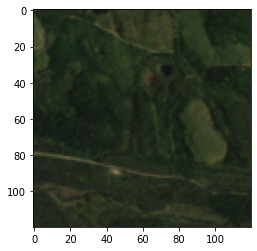

In [64]:
import matplotlib.pyplot as plt

_OPTICAL_MAX_VALUE = 2000. # magic number from some google guys
img = np.stack(band_stack) / _OPTICAL_MAX_VALUE # (C, W, H)
img = np.clip(img, 0, 1)
plt.imshow(np.transpose(img))


In [65]:
import json

In [70]:
with open(os.path.join(data_dir, patches[idx], "{}_labels_metadata.json".format(patches[idx])), 'r') as f:
    metadata = json.load(f)

metadata

In [75]:
from collections import Counter

c = Counter()
c.update(metadata['labels'])
c

Counter({'Coniferous forest': 1,
         'Mixed forest': 1,
         'Transitional woodland/shrub': 1,
         'Water bodies': 1})

In [80]:
from collections import Counter
from tqdm.notebook import tqdm
import pickle

label_counts = Counter()
for patch in tqdm(patches):
    with open(os.path.join(data_dir, patch, "{}_labels_metadata.json".format(patch)), 'r') as f:
        metadata = json.load(f)
        label_counts.update(metadata['labels'])
print(label_counts)

with open("label_counts_cache.pkl", "wb") as f:
    pickle.dump(label_counts, f)


Counter({'Mixed forest': 102586, 'Coniferous forest': 101379, 'Non-irrigated arable land': 90049, 'Transitional woodland/shrub': 79644, 'Broad-leaved forest': 76838, 'Land principally occupied by agriculture, with significant areas of natural vegetation': 74965, 'Complex cultivation patterns': 55480, 'Pastures': 46618, 'Sea and ocean': 42459, 'Water bodies': 39132, 'Discontinuous urban fabric': 33062, 'Peatbogs': 10441, 'Agro-forestry areas': 8756, 'Natural grassland': 7696, 'Continuous urban fabric': 7691, 'Industrial or commercial units': 5328, 'Water courses': 4659, 'Sclerophyllous vegetation': 4150, 'Vineyards': 3634, 'Permanently irrigated land': 3550, 'Olive groves': 3257, 'Inland marshes': 2744, 'Moors and heathland': 2377, 'Sport and leisure facilities': 2369, 'Bare rock': 2297, 'Mineral extraction sites': 2174, 'Annual crops associated with permanent crops': 2099, 'Fruit trees and berry plantations': 1954, 'Road and rail networks and associated land': 1529, 'Rice fields': 940

In [85]:
random.choice(label_counts.keys(), 2)

TypeError: choice() takes 2 positional arguments but 3 were given